<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/master/Transformer/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
collab = False
if collab:
    !pip install tensorflow-gpu --quiet
    !git clone https://github.com/mizzmir/NLP.git

In [2]:
import os
import sys
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

if collab:
  sys.path.insert(0, r"./NLP/utilities")
  data_dir = "./NLP/data"
else:
  sys.path.insert(0, r"../utilities")
  data_dir = "../data"

from utils import *
from model import *
from TransformerTrainer import *

In [3]:
data = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
print("input shape ", data.shape)
padding_mask = makePaddingMask(data)

encoder = Encoder(embedding_size=10,
                  max_sentence_len=1000,
                  vocab_size=3000,
                  blocks_amount=3,
                  heads_number=5, 
                  dff=2048)
encoder_out  = encoder(data, mask=padding_mask)
print(encoder_out.shape)

input shape  (64, 62)
(64, 62, 10)


In [4]:
input_data = np.ones((64, 26))
mask = makeSequenceMask(input_data.shape[1])
print("Decoder input shape ", input_data.shape)
blocks_amount = 2
heads = 5
en_vocab_size = 100
fr_vocab_size = 200
decoder = Decoder(embedding_size=10,
                  max_sentence_len=1000,
                  vocab_size=100,
                  blocks_amount=3,
                  heads_number=5, 
                  dff=2048)
"""
decoder masks are :
- encoder_padding_mask - padding mask made on encoder input data
- decoder sequences mask - sequence mask made on decoder input data
"""
decoder_out  = decoder(encoder_out, input_data, pad_mask=None, elements_mask=None)
print("decoder_out ", decoder_out.shape)

Decoder input shape  (64, 26)
decoder_out  (64, 26, 10)


In [5]:
transformer_model = Transformer(embedding_size=512,
                                dff=2048,
                                input_max_seq_length=2000,
                                output_max_seq_length=1855,
                                input_vocab_size=4980,
                                output_vocab_size=7001,
                                encoder_blocks=4,
                                decoder_blocks=2,
                                heads=8)

# input_data and output_data
input_data = tf.random.uniform((64, 52), dtype=tf.int64, minval=0, maxval=100)
output_data = tf.random.uniform((64, 29), dtype=tf.int64, minval=0, maxval=250)

encoder_pad_mask = makePaddingMask(input_data)
elements_mask = makeSequenceMask(output_data.shape[1])
print("output_data ", output_data.shape)
print("elements_mask ", elements_mask.shape)
transformer_output = transformer_model(input_data, output_data, encoder_pad_mask, elements_mask)
print(transformer_output.shape)

output_data  (64, 29)
elements_mask  (29, 29)
(64, 29, 7001)


In [6]:
BATCH_SIZE = 64
EPOCHS = 10
num_layers = 4 # 6
d_model = 128 # 512
dff = 512  # 2048
num_heads = 8 

In [7]:
    data_dir = "../data"
    # reading data

    en_lines, fr_lines = read_data_files(data_dir, ("small_vocab_en", "small_vocab_fr"))
    """
    data = read_data(os.path.join(data_dir, "fra-eng"), "fra.txt")
    en_lines, fr_lines = list(zip(*data))
    
    en_lines = en_lines[:30000]
    fr_lines = fr_lines[:30000]
    """
    en_lines = [normalize(line) for line in en_lines]
    fr_lines = [normalize(line) for line in fr_lines]

    en_train, en_test, fr_train, fr_test = train_test_split(en_lines, fr_lines, shuffle=True, test_size=0.1)

    fr_train_in = ['<start> ' + line for line in fr_train]
    fr_train_out = [line + ' <end>' for line in fr_train]

    fr_test_in = ['<start> ' + line for line in fr_test]
    fr_test_out = [line + ' <end>' for line in fr_test]

    fr_tokenizer = Tokenizer(filters='')
    en_tokenizer = Tokenizer(filters='')

    input_data = [fr_train_in, fr_train_out, fr_test_in, fr_test_out, fr_test, fr_train]
    fr_train_in, fr_train_out, fr_test_in, fr_test_out, fr_test, fr_train = tokenizeInput(input_data,
                                                                                          fr_tokenizer)

    input_data = [en_train, en_test]
    en_train, en_test = tokenizeInput(input_data, en_tokenizer)

    en_vocab_size = len(en_tokenizer.word_index)+1
    fr_vocab_size = len(fr_tokenizer.word_index)+1
    print("en_vocab {}\nfr_vocab {}" .format(en_vocab_size, fr_vocab_size))

reading data from  ../data/small_vocab_en
reading data from  ../data/small_vocab_fr
en_vocab 203
fr_vocab 336


In [8]:
trainer = TransformerTrainer(BATCH_SIZE, num_layers, d_model, dff, num_heads, 1)

In [9]:
losses, accuracy= trainer.train([en_train, fr_train_in, fr_train_out], [en_test, fr_test_in, fr_test_out], [en_tokenizer, fr_tokenizer], 20)

en_vocab 203
fr_vocab 336
Number of devices: 4
creating dataset...
training from scratch
INFO:tensorflow:batch_all_reduce: 170 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 170 all-reduces wi

Epoch 18 training Loss 0.1788 Accuracy 0.6262  test Loss 0.1809 Accuracy 0.6857
           English   : ['new jersey is sometimes pleasant during november but it is warm in june .']
           Predicted : new jersey est parfois agreable au mois de novembre mais il est chaud en juin .
           Correct   : ['new jersey est parfois agreable au mois de novembre mais il est chaud en juin . <end>']
Epoch 19 training Loss 0.1687 Accuracy 0.6263  test Loss 0.1646 Accuracy 0.6861
           English   : ['paris is usually beautiful during spring but it is busy in summer .']
           Predicted : paris est generalement beau au printemps mais il est occupe en ete .
           Correct   : ['paris est generalement beau au printemps mais il est occupe en ete . <end>']
Epoch 20 training Loss 0.1590 Accuracy 0.6264  test Loss 0.1683 Accuracy 0.6864
           English   : ['our least liked fruit is the lemon but their least liked is the grapefruit .']
           Predicted : notre fruit est moins aime 

In [10]:
train_losses, test_losses = losses 
train_accuracyVec, test_accuracyVec = accuracy

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_losses, label="train_loss")
fig_plot.plot(test_losses, label="test_loss")
fig_plot.legend(loc="upper right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("loss")
fig_plot.grid(linestyle="--")
fig.savefig("losses_plot.png")

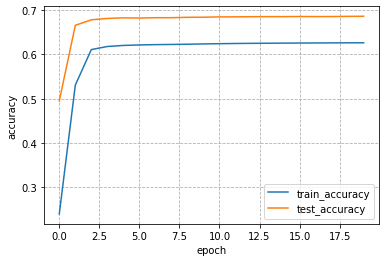

In [12]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_accuracyVec, label="train_accuracy")
fig_plot.plot(test_accuracyVec, label="test_accuracy")
fig_plot.legend(loc="lower right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("accuracy")
fig_plot.grid(linestyle="--")
fig.savefig("accuracy_plot.png")

In [13]:
transformer_model = trainer.transformer_model
checkpoint_path = trainer.checkpoint_path

loadWeights(transformer_model, checkpoint_path)

Latest checkpoint restored!!
